# Cyrillic CNN with data augmentation


In this notebook I train a CNN either for capitalized or small hand written cyrillic letters.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")


print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


## Data preparation


### Preparation of data inputs 

* Define labels
* Read relevant data entries from csv files for capitalized or not letters for train, test and validation
* produce also training directories for convenient use of pytorch image data loading

In [2]:
labels = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й',
          'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф',
          'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']

In [3]:
len(labels)

33

In [4]:
capitals = False

if capitals:
    q = 'Russian > -1 and letters81 > 41'
else:
    q = 'Russian > -1 and letters81 <= 41'

In [5]:
datatypes = ["train", "test", "validation"]

In [6]:

if capitals:
    path = 'Data'
    labels.remove('Ъ')
    labels.remove('Ь')
else:
    path = 'SmallData'

In [8]:

for data in datatypes:
    df = pd.read_csv(f"cyrillic_data/{data}.csv")
    dfrussian = df.query(q)
    for i in range(len(labels)):
        Path(f"cyrillic_data/{path}/{data}/{labels[i]}").mkdir(parents=True, exist_ok=True)
    for i in range(len(labels)):
        dfcut = dfrussian.query(f'Russian == {i}')
        for index,col in dfcut.iterrows():
            os.system(f"cp cyrillic_data/allgr/{col['filename']} cyrillic_data/{path}/{data}/{labels[i]}")
    
    

cp: cannot stat 'cyrillic_data/allgr/2_2_1496_20190729100538': No such file or directory
cp: cannot stat '—': No such file or directory
cp: cannot stat 'копия.png': No such file or directory
cp: cannot stat 'cyrillic_data/allgr/32_21_929_20190729110539': No such file or directory
cp: cannot stat '—': No such file or directory
cp: cannot stat 'копия.png': No such file or directory
cp: cannot stat 'cyrillic_data/allgr/32_26_1017_20190729110540': No such file or directory
cp: cannot stat '—': No such file or directory
cp: cannot stat 'копия.png': No such file or directory
cp: cannot stat 'cyrillic_data/allgr/32_21_25_20190729110504': No such file or directory
cp: cannot stat '—': No such file or directory
cp: cannot stat 'копия.png': No such file or directory
cp: cannot stat 'cyrillic_data/allgr/32_21_703_20190729110538': No such file or directory
cp: cannot stat '—': No such file or directory
cp: cannot stat 'копия.png': No such file or directory
cp: cannot stat 'cyrillic_data/allgr/32_2

In [16]:
path = 'cyrillic_data/SmallData'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        
print('Images: ',len(img_names))

Images:  53737


In [17]:
img_names[:10]

['cyrillic_data/SmallData/train/Я/41_41_900_20190729112437.png',
 'cyrillic_data/SmallData/train/Я/41_41_1392_20190729112456.png',
 'cyrillic_data/SmallData/train/Я/41_41_961_20190729112437.png',
 'cyrillic_data/SmallData/train/Я/41_41_363_20190729112354.png',
 'cyrillic_data/SmallData/train/Я/41_41_852_20190729112437.png',
 'cyrillic_data/SmallData/train/Я/41_41_733_20190729112436.png',
 'cyrillic_data/SmallData/train/Я/41_41_1373_20190729112456.png',
 'cyrillic_data/SmallData/train/Я/41_41_296_20190729112354.png',
 'cyrillic_data/SmallData/train/Я/41_41_1276_20190729112455.png',
 'cyrillic_data/SmallData/train/Я/41_41_695_20190729112436.png']

In [18]:
len(labels)

33

### Preparation of pytorch data loading

* define pytorch data augmentation transformations
* Note the resizing and gray scaling is done both for training and val data
* For only training random rotations and translations are included

In [31]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5, fill=1), 
        transforms.RandomRotation(15, fill=1),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ])
}

Use ImageFolder dataset and use data transforms from above

Initialise data loaders

In [32]:
root = './cyrillic_data/SmallData'
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=data_transforms['train'])
val_data = datasets.ImageFolder(os.path.join(root, 'validation'), transform=data_transforms['val'])

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(val_data)}')

['Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
Training images available: 42996
Testing images available:  5353


### Visualize validation and train examples

Below validation and train examples are visualized. Onew can see the impact of normalization and data augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 266, 530)


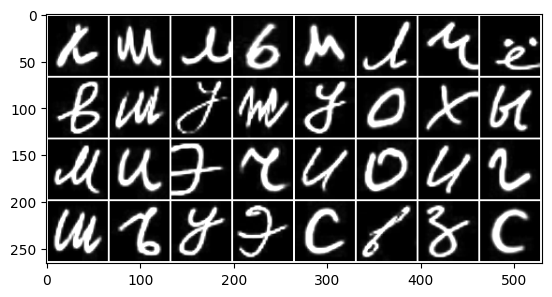

1125132913122403252072015222813930249159425272030183818


In [33]:
import torchvision

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img    
    npimg = 1-img.numpy()
    print(npimg.shape)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray_r')
    plt.show()



dataiter = iter(val_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(''.join('%1s' % labels[j].numpy() for j in range(32)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 266, 530)


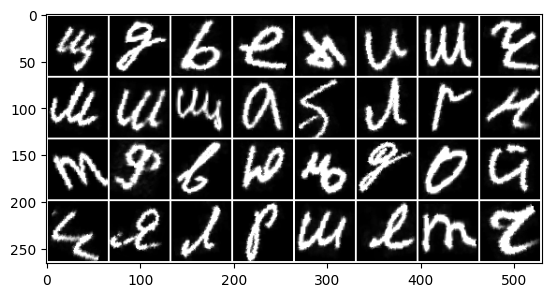

2652961492524132526121217141921331275151093212172561924


In [34]:
# For train images impact of data augmentation is visible
dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(''.join('%1s' % labels[j].numpy() for j in range(32)))

In [35]:
len(class_names)

33

## Define model

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, len(class_names)) 
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x): 
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.dropOut(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 13 * 13) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device ="cuda"
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=33, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [41]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            320
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            9,248
├─BatchNorm2d: 1-4                       64
├─Conv2d: 1-5                            18,496
├─BatchNorm2d: 1-6                       128
├─Conv2d: 1-7                            36,928
├─BatchNorm2d: 1-8                       128
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           1,384,576
├─Linear: 1-11                           4,257
├─Dropout: 1-12                          --
Total params: 1,454,209
Trainable params: 1,454,209
Non-trainable params: 0

In [42]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [43]:
epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []

In [45]:
epochs = 2
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    # apply model to validation batch
                    images, labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')
        



Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 96.484%
Epoch: 1, Mini-Batches Completed: 400 Val Accuracy = 97.889%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 96.367%
Epoch: 1, Mini-Batches Completed: 800 Val Accuracy = 97.609%
Epoch: 1, Mini-Batches Completed: 1200 Train Accuracy = 96.367%
Epoch: 1, Mini-Batches Completed: 1200 Val Accuracy = 97.740%


Epoch 1 summary stats:
Train Loss: 0.0036, Train Accuracy = 96.367%
Val Loss: 0.0026, Val Accuracy = 97.740%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 96.930%
Epoch: 2, Mini-Batches Completed: 400 Val Accuracy = 97.702%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 96.895%
Epoch: 2, Mini-Batches Completed: 800 Val Accuracy = 97.852%
Epoch: 2, Mini-Batches Completed: 1200 Train Accuracy = 96.919%
Epoch: 2, Mini-Batches Completed: 1200 Val Accuracy = 98.225%


Epoch 2 summary stats:
Train Loss: 0.0032, Train Accuracy = 96.919%
Val Loss: 0.0021, Val Accuracy = 98.225%






In [51]:
running_total

42996.0

In [47]:
len(loss_log)

8

Text(0, 0.5, 'Loss')

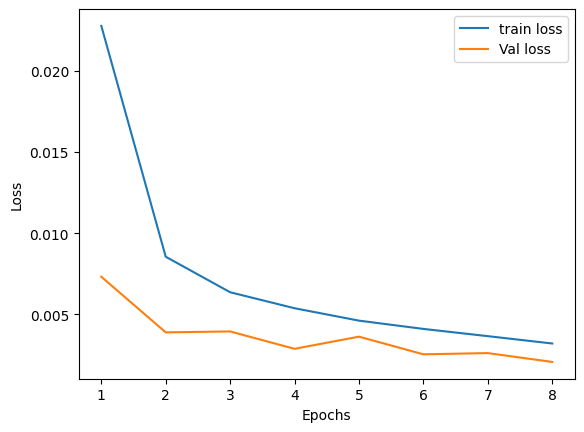

In [54]:
epochs = np.arange(1,9)
plt.plot(epochs,loss_log, label = "train loss")
plt.plot(epochs,val_loss_log, label = "Val loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

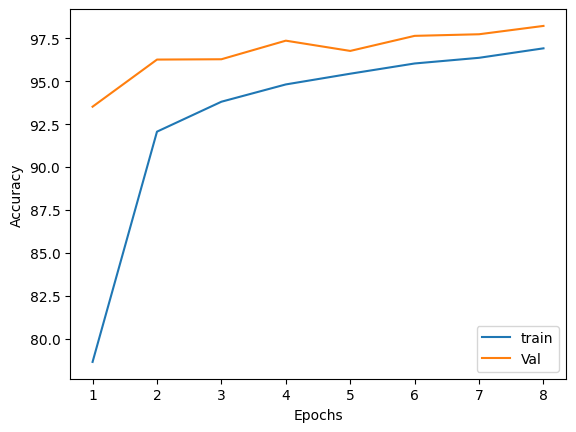

In [55]:
epochs = np.arange(1,9)
plt.plot(epochs,accuracy_log, label = "train")
plt.plot(epochs,val_accuracy_log, label = "Val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
PATH = './cyrillic_pytorch_aug.pth'
torch.save(model.state_dict(), PATH)